# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [294]:
import twitter

CONSUMER_KEY = "1w8Ph7u118iOEFtSr55jbouCj"
CONSUMER_SECRET = "mNbLMj3nGszNGPabJXFP0RmX8Av0eoM0XrAso0davvXmNBtqSR"

ACCESS_TOKEN_KEY = "219939677-T98l4vUau7NkpInpZHqIgM1CcCJ52HA9n3Wqylru"
ACCESS_TOKEN_SECRET = "b3p3EgKUkITt4ty6mDqxfcTCi1DI60wUufZRi5YYnhbAu"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [360]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    # your code here
    filtered = []
    tweets = api.GetUserTimeline(user_id, count=200)
    for tweet in tweets:
        tweet_dict = tweet.AsDict()
        tw_arr = [f for f in tweet_dict['text'].split() if f[:4:] != 'http']
        if len(tw_arr) != 0 and tweet_dict['text'][:2:] != 'RT' and tweet_dict['text'][0] != '@':
            nt = ''
            for tw in tw_arr:
                nt = nt + ' ' + tw
            tweet_dict['text'] = nt
            filtered.append(tweet_dict)
    return filtered

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [414]:
import re

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_words(text):
    """returns list of words"""
    sym = ['\"', "[", ']', '"', '\'']
    filtered = []
    if text == '':
        return 0
    text = re.sub('[.,-?/|\><{}()=#+;:^&*!$’…‘—]', ' ', text)
    text.replace('\"', ' ')
    try:       
        emojipattern = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    except re.error:
        emojipattern = re.compile(u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])')
    text = emojipattern.sub(' ', text)
    patternsym = re.compile(u'([\u2010-\u2027])')
    text = patternsym.sub(' ', text)
    words = [f for f in text.split()]
    for word in words:
        if word == 'amp' or word == 'via':
            continue
        if '\'s' in word:
            word = word[:len(word) - 2:]
        else:
            if '\'' in word:
                continue
        if word != '' and word[0] in sym:
            word = word[1::]
        if word != '' and word[len(word) - 1] in sym:
            word = word[:len(word) - 1:]
        if len(word) > 2 and len(word) < 17 and word[0] != '@' and not is_number(word) and 'n\'t' not in word and 'it\'s' not in word:
            filtered.append(word)
    return filtered

In [415]:
print get_words("Here are different words!")

['Here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [112]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/masha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [405]:
def get_tokens(words):
    """returns list of tokens"""
    # your code here
    stop = False
    tokens = []
    languages = ['danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 'italian', 'norwegian', 'portuguese', 'russian', 'spanish', 'swedish', 'turkish']
    for word in words:
        word = word.lower()
        to_add = True
        for lang in languages:
            if word in stopwords.words(lang):
                to_add = False
        if to_add:
            tokens.append(word)
    return tokens

In [410]:
print get_tokens(["here", "are", "different", "words"])

['different', 'words']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [370]:
def get_tweet_tokens(tweet):
    # your code here
    return get_tokens(get_words(tweet))

In [409]:
get_tweet_tokens("Here are different words!")

['different', 'words']

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [417]:
import time

def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    # your code here
    # save intermediate result
    
    uidlist = df_users.uid.tolist()
    uidtokenlist = []
    
    for uid in uidlist:
        try:
            try:
                tweets_arr = get_user_tweets(uid)
            except:
                try:
                    time.sleep(api.GetSleepTime("statuses/user_timeline"))
                except:
                    time.sleep(30)
                    tweets_arr = get_user_tweets(uid)
            finally:
                token_freq = {}
                for tweet in tweets_arr:
                    tokens = get_tweet_tokens(tweet['text'])
                    for token in tokens:
                        if token in token_freq.keys():
                            token_freq[token] += 1
                        else:
                            token_freq.update({token: 1})
                uidtokenlist.append(token_freq)
        except:
            print "Exception"
            return uidlist[:len(uidtokenlist):], uidtokenlist   
    return uidlist, uidtokenlist

In [418]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])


users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

In [420]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens)

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [438]:
%pylab inline
from wordcloud import WordCloud, ImageColorGenerator
from scipy.misc import imread

def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    # your code here
    va = vs.toarray()
    col_sum = np.sum(va, axis=0)
    tokens = v.get_feature_names()
    tuples = zip(tokens, col_sum)
    sorted_tuples = sorted(tuples, key=lambda x: x[1], reverse=True)
    
    cloud_mask = imread('cloud.png', flatten=True)
    colour_mask = imread('rainbow4.png')
    wordcloud = WordCloud(font_path='QuinchoScript.ttf', background_color='white', mask=cloud_mask).generate_from_frequencies(sorted_tuples)
    image_colors = ImageColorGenerator(colour_mask)
    plt.imshow(wordcloud.recolor(color_func=image_colors))
    plt.axis('off')
    plt.savefig('wordcloud.png', dpi=300)
    plt.show()
    return

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


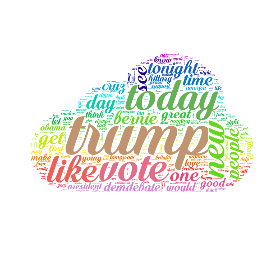

In [442]:
draw_tag_cloud(v, vs_all)